In [1]:
import duckdb
import matplotlib.pyplot as plt
import numpy as np
import pandas

con = duckdb.connect('../data/db_files/file.db')

# Consulta 1:
Crescimento do PIB per capita e das emissões de GEE's per capita

In [2]:
q = """
    SELECT
        sub.ano,
        sub.media_pib AS mp,
        sub.media_gee AS mg
    FROM (
        SELECT 
            ano,
            AVG(pib_per_capita) AS media_pib,
            AVG(gee_per_capita) AS media_gee
        FROM infos_anuais_paises
        GROUP BY ano
    ) AS sub
    WHERE
        mp IS NOT Null AND
        mg IS NOT Null
"""

resultado = con.execute(q).fetchall()

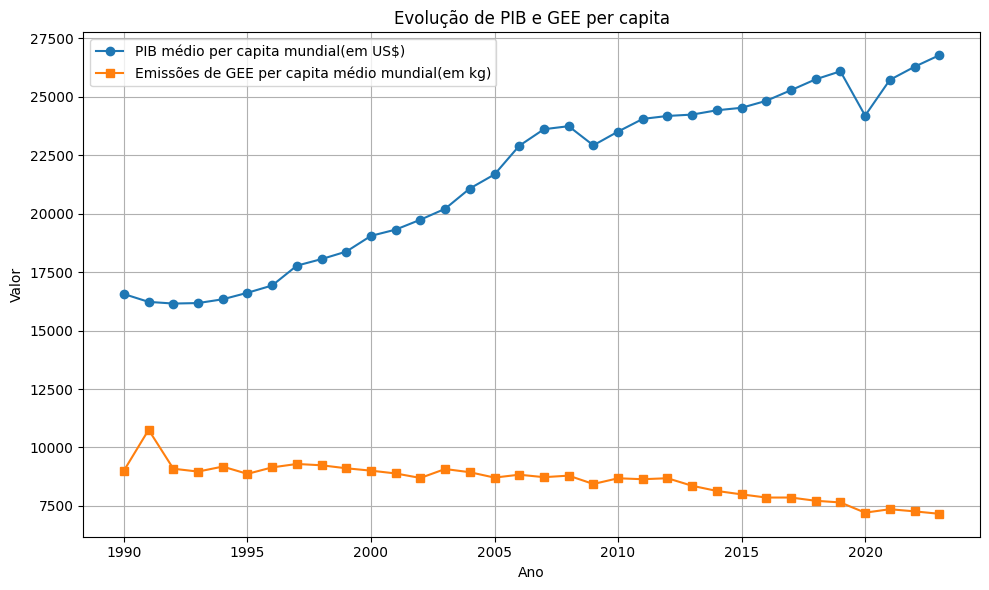

In [3]:

# Separar os dados em três listas
anos = [d[0] for d in resultado]
pib = [d[1] for d in resultado]
gee = [(d[2])*10**3 for d in resultado]

# Criar o gráfico
plt.figure(figsize=(10, 6))
plt.plot(anos, pib, label='PIB médio per capita mundial(em US$)', marker='o')
plt.plot(anos, gee, label='Emissões de GEE per capita médio mundial(em kg)', marker='s')

# Personalização
plt.xlabel('Ano')
plt.ylabel('Valor')
plt.title('Evolução de PIB e GEE per capita')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Mostrar o gráfico
plt.show()


# Consulta 2:
Verificando a relação entre a fonte de energia mais utilizada no país e sua variação de temperatura anual e número de mortes por desastres naturais no Brasil

In [4]:
q="""
SELECT
    ano,
    fonte_carvao,
    fonte_nuclar,
    fonte_gas,
    fonte_petroleo,
    fonte_solar,
    fonte_hidreletrica,
    anomalia_temperatura,
    morte_desastes_naturais,
FROM infos_anuais_paises
WHERE 
    codigo LIKE 'BRA' AND
    fonte_carvao IS NOT NULL AND
    fonte_nuclar IS NOT NULL AND
    fonte_gas IS NOT NULL AND
    fonte_petroleo IS NOT NULL AND
    fonte_solar IS NOT NULL AND
    fonte_hidreletrica IS NOT NULL AND
    anomalia_temperatura IS NOT NULL AND
    morte_desastes_naturais IS NOT NULL 
"""

resultado=con.execute(q).fetchall()


In [5]:
tab = con.query(q).show()

┌───────┬──────────────┬──────────────┬────────────┬────────────────┬───────────────┬────────────────────┬──────────────────────┬─────────────────────────┐
│  ano  │ fonte_carvao │ fonte_nuclar │ fonte_gas  │ fonte_petroleo │  fonte_solar  │ fonte_hidreletrica │ anomalia_temperatura │ morte_desastes_naturais │
│ int32 │    double    │    double    │   double   │     double     │    double     │       double       │        double        │          int32          │
├───────┼──────────────┼──────────────┼────────────┼────────────────┼───────────────┼────────────────────┼──────────────────────┼─────────────────────────┤
│  2000 │    6.4147906 │    0.7279309 │  4.1177244 │      46.296303 │           0.0 │          38.192924 │           -0.5304143 │                     147 │
│  2001 │     6.475143 │    1.7518144 │  5.3468595 │      47.856968 │           0.0 │           34.24804 │          -0.20988162 │                     118 │
│  2002 │    6.1277623 │    1.6489844 │  6.1767874 │      45.865

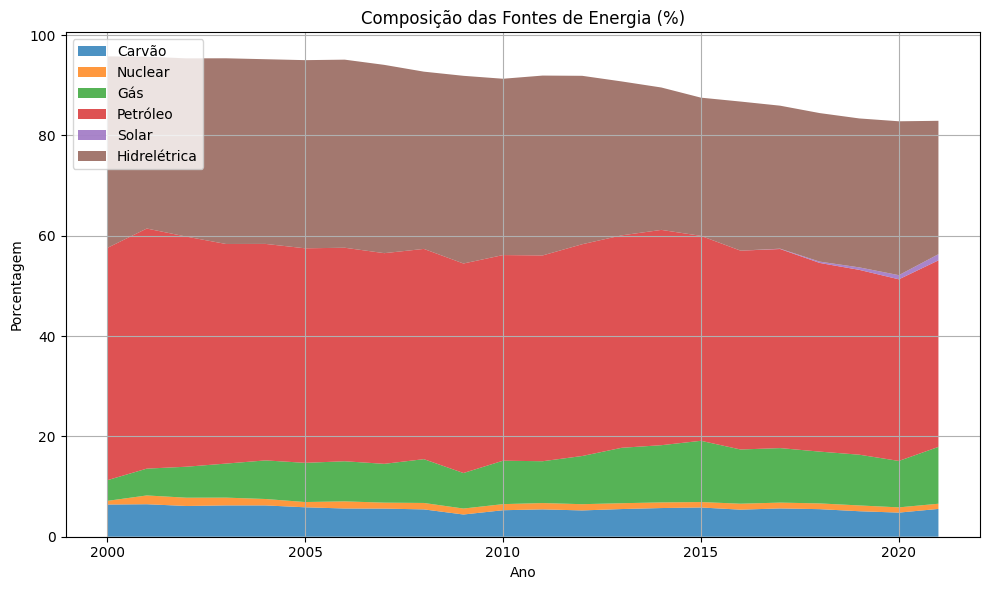

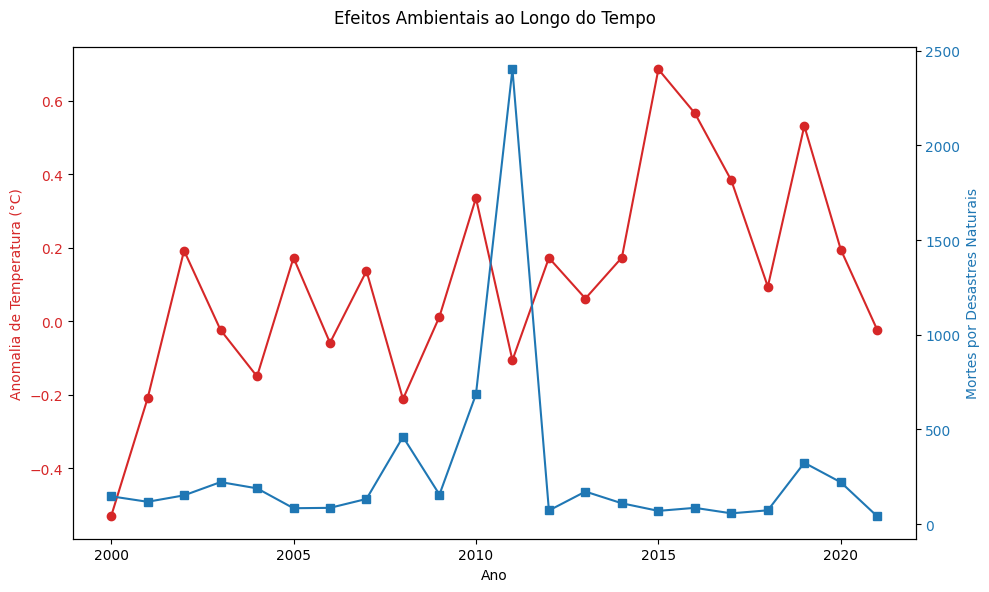

In [6]:
anos = np.array([r[0] for r in resultado])

fonte_carvao = np.array([r[1] for r in resultado])
fonte_nuclear = np.array([r[2] for r in resultado])
fonte_gas = np.array([r[3] for r in resultado])
fonte_petroleo = np.array([r[4] for r in resultado])
fonte_solar = np.array([r[5] for r in resultado])
fonte_hidreletrica = np.array([r[6] for r in resultado])

anomalia_temperatura = np.array([r[7] for r in resultado])
mortes_desastres = np.array([r[8] for r in resultado])

# ============
# GRÁFICO 1 – Fontes de Energia (barras empilhadas)
# ============
fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.stackplot(
    anos,
    fonte_carvao,
    fonte_nuclear,
    fonte_gas,
    fonte_petroleo,
    fonte_solar,
    fonte_hidreletrica,
    labels=[
        "Carvão", "Nuclear", "Gás", "Petróleo", "Solar", "Hidrelétrica"
    ],
    alpha=0.8
)
ax1.set_title("Composição das Fontes de Energia (%)")
ax1.set_ylabel("Porcentagem")
ax1.set_xlabel("Ano")
ax1.legend(loc="upper left")
ax1.grid(True)
plt.tight_layout()
plt.show()

# ============
# GRÁFICO 2 – Temperatura e Mortes (eixos duplos)
# ============
fig, ax2 = plt.subplots(figsize=(10, 6))

# Curva da temperatura
ax2.set_xlabel("Ano")
ax2.set_ylabel("Anomalia de Temperatura (°C)", color="tab:red")
ax2.plot(anos, anomalia_temperatura, color="tab:red", marker='o', label="Anomalia de Temperatura")
ax2.tick_params(axis='y', labelcolor="tab:red")

# Segundo eixo: mortes por desastres
ax3 = ax2.twinx()
ax3.set_ylabel("Mortes por Desastres Naturais", color="tab:blue")
ax3.plot(anos, mortes_desastres, color="tab:blue", marker='s', label="Mortes")
ax3.tick_params(axis='y', labelcolor="tab:blue")

fig.suptitle("Efeitos Ambientais ao Longo do Tempo")
fig.tight_layout()
plt.show()


# Consulta 3:
Comparação por continente da porcentagem média da participação de fontes renováveis e não renováveis no consumo de cada continente

In [7]:
q="""
SELECT 
    continente,
    ROUND(AVG(fonte_solar + fonte_hidreletrica), 2) AS renovaveis,
    ROUND(AVG(fonte_carvao + fonte_gas + fonte_petroleo + fonte_nuclar), 2) AS nao_renovaveis,
    ROUND(AVG(pib_per_capita), 2) as "pib_percapita(US$)"
FROM infos_anuais_paises
GROUP BY continente
ORDER BY renovaveis DESC;
"""

r=con.execute(q).fetchdf()


In [8]:
con.sql(q).show()

┌───────────────┬────────────┬────────────────┬────────────────────┐
│  continente   │ renovaveis │ nao_renovaveis │ pib_percapita(US$) │
│    varchar    │   double   │     double     │       double       │
├───────────────┼────────────┼────────────────┼────────────────────┤
│ South America │      22.01 │           77.0 │           15558.79 │
│ Oceania       │      21.96 │          78.21 │           11650.04 │
│ Europe        │       9.72 │          88.69 │            37239.8 │
│ North America │       9.68 │          87.28 │            26721.9 │
│ Asia          │       4.95 │          94.39 │            25232.5 │
│ Africa        │       2.51 │           96.0 │            5783.35 │
└───────────────┴────────────┴────────────────┴────────────────────┘



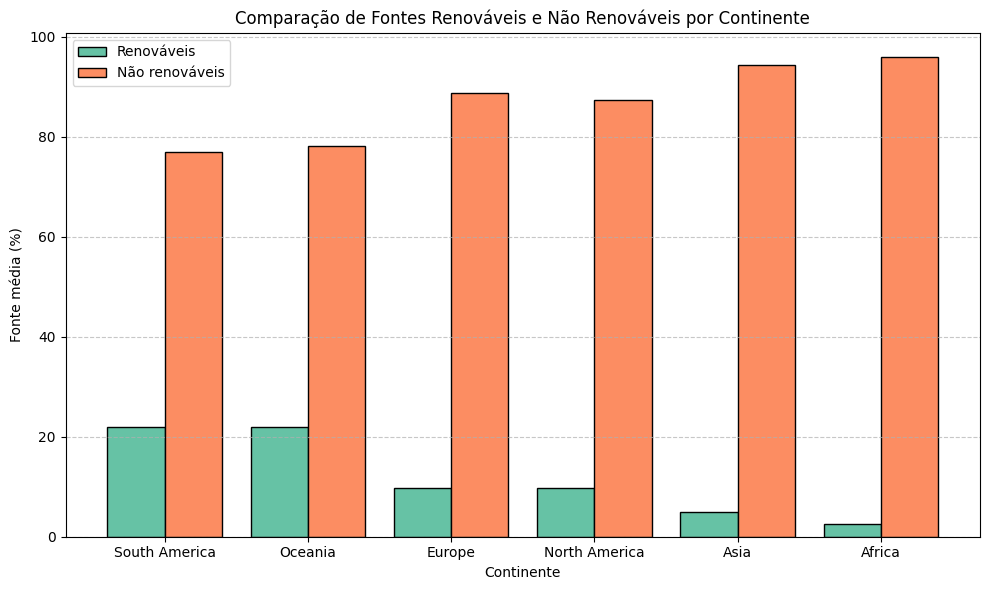

In [9]:
# ============
# Plotando o gráfico de barras
# ============
continentes = r["continente"]
renovaveis = r["renovaveis"]
nao_renovaveis = r["nao_renovaveis"]

x = np.arange(len(continentes))
largura = 0.4  # largura de cada barra

fig, ax = plt.subplots(figsize=(10, 6))

# Barras lado a lado
b1 = ax.bar(x - largura/2, renovaveis, width=largura, label='Renováveis', color='#66c2a5', edgecolor='black')
b2 = ax.bar(x + largura/2, nao_renovaveis, width=largura, label='Não renováveis', color='#fc8d62', edgecolor='black')

# Rótulos e ajustes
ax.set_xlabel('Continente')
ax.set_ylabel('Fonte média (%)')
ax.set_title('Comparação de Fontes Renováveis e Não Renováveis por Continente')
ax.set_xticks(x)
ax.set_xticklabels(continentes)
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

# Consulta 4:
Países detentores das maiores anomalias de temperatura de cada ano

In [10]:
q="""
SELECT 
    ano, 
    nome, 
    anomalia_temperatura
FROM (
    SELECT 
        ano,
        nome,
        anomalia_temperatura,
        RANK() OVER (PARTITION BY ano ORDER BY anomalia_temperatura DESC) AS rank_anomalia
    FROM infos_anuais_paises
    WHERE anomalia_temperatura IS NOT NULL
    QUALIFY rank_anomalia = 1
)
ORDER BY ano
"""

r=con.execute(q).fetchall()

In [11]:
con.sql(q).show()

┌───────┬──────────────────────────┬──────────────────────┐
│  ano  │           nome           │ anomalia_temperatura │
│ int32 │         varchar          │        double        │
├───────┼──────────────────────────┼──────────────────────┤
│  1960 │ Lebanon                  │           0.37372816 │
│  1961 │ Paraguay                 │           0.44635916 │
│  1962 │ Bahrain                  │            0.5276861 │
│  1963 │ Paraguay                 │           0.30049977 │
│  1964 │ Central African Republic │            0.5567338 │
│  1965 │ Central African Republic │           0.12888718 │
│  1966 │ Georgia                  │            1.3220006 │
│  1967 │ Uruguay                  │        -0.0037249725 │
│  1968 │ Argentina                │        -0.0066517196 │
│  1969 │ Cabo Verde               │           0.36923647 │
│    ·  │     ·                    │                 ·    │
│    ·  │     ·                    │                 ·    │
│    ·  │     ·                    │    

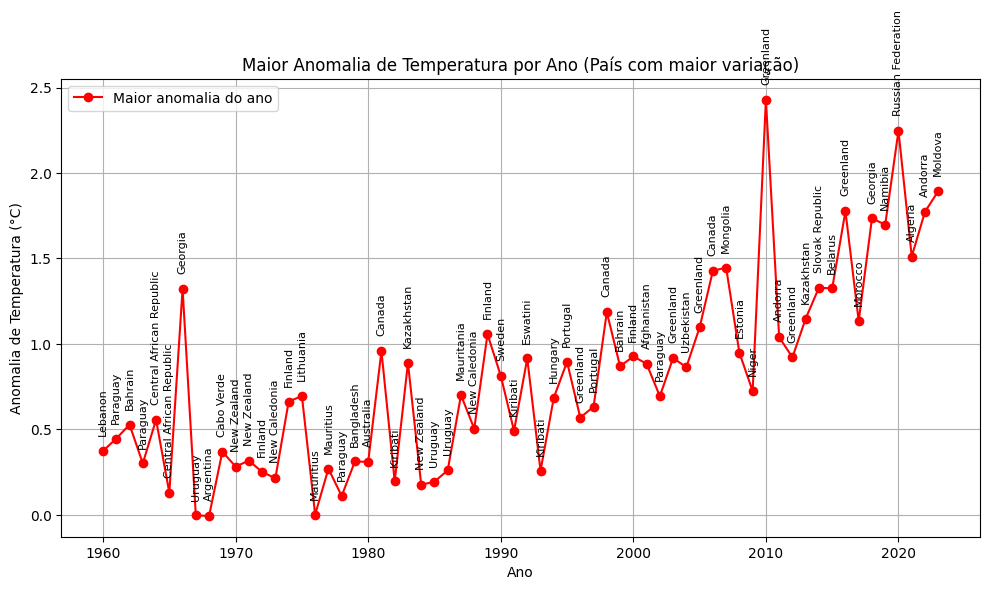

In [12]:
df = con.execute(q).fetchdf()

# Separar os dados
anos = df["ano"]
anomalias = df["anomalia_temperatura"]
paises = df["nome"]

# Criar o gráfico
plt.figure(figsize=(10, 6))
plt.plot(anos, anomalias, marker='o', linestyle='-', color='red', label='Maior anomalia do ano')

# Adiciona o nome do país em cada ponto (opcional)
for i in range(len(anos)):
    plt.text(anos[i], anomalias[i] + 0.1, paises[i], ha='center', fontsize=8, rotation=90)

# Estilização
plt.title('Maior Anomalia de Temperatura por Ano (País com maior variação)')
plt.xlabel('Ano')
plt.ylabel('Anomalia de Temperatura (°C)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Consulta 5:
Top 10 países que mais aumentaram seu consumo de energia oriunda de fontes renováveis

In [13]:
q="""
WITH renovaveis_por_ano AS (
    SELECT 
        nome,
        ano,
        (fonte_solar + fonte_hidreletrica) AS total_renovavel
    FROM infos_anuais_paises
    WHERE ano IN (2000, 2020)
),
delta_renovavel AS (
    SELECT
        r1.nome,
        ROUND(r1.total_renovavel, 2) AS renovavel_2000,
        ROUND(r2.total_renovavel, 2) AS renovavel_2020,
        ROUND(r2.total_renovavel - r1.total_renovavel, 2) AS aumento_renovavel
    FROM renovaveis_por_ano r1
    JOIN renovaveis_por_ano r2 ON r1.nome = r2.nome AND r1.ano = 2000 AND r2.ano = 2020
)
SELECT *
FROM delta_renovavel
ORDER BY aumento_renovavel DESC
LIMIT 10;
"""

In [14]:
con.sql(q).show()

┌───────────────┬────────────────┬────────────────┬───────────────────┐
│     nome      │ renovavel_2000 │ renovavel_2020 │ aumento_renovavel │
│    varchar    │     double     │     double     │      double       │
├───────────────┼────────────────┼────────────────┼───────────────────┤
│ Ecuador       │          21.61 │           35.0 │             13.39 │
│ Venezuela, RB │          24.09 │          33.43 │              9.34 │
│ Italy         │           6.23 │          11.54 │              5.31 │
│ Greece        │           2.93 │           7.39 │              4.46 │
│ China         │           5.57 │          10.02 │              4.44 │
│ Japan         │           4.01 │            8.4 │              4.39 │
│ Switzerland   │          29.91 │           34.1 │              4.19 │
│ Israel        │           0.04 │           3.86 │              3.82 │
│ Spain         │           5.74 │           9.44 │              3.71 │
│ Slovenia      │          14.45 │          18.02 │             

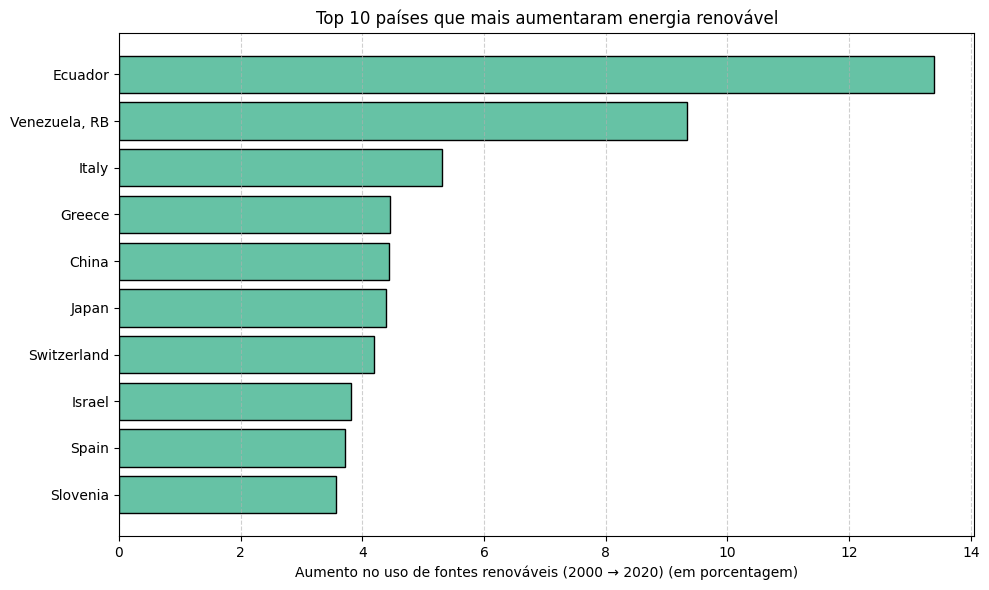

In [15]:
# Executa a consulta e armazena em DataFrame
df = con.execute(q).fetchdf()

# Dados para o gráfico
nomes = df["nome"]
aumentos = df["aumento_renovavel"]

# Plotar gráfico de barras horizontais
plt.figure(figsize=(10, 6))
bars = plt.barh(nomes, aumentos, color="#66c2a5", edgecolor="black")

# Rótulos e estética
plt.xlabel('Aumento no uso de fontes renováveis (2000 → 2020) (em porcentagem)')
plt.title('Top 10 países que mais aumentaram energia renovável')
plt.gca().invert_yaxis()  # Coloca o maior no topo
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()